In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical Data

In [4]:
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

# Removing noise on heating scheme | the removed coluns are shots from 1996
DB5 = DB5[~DB5["AUXHEAT"].isin(["UNKNOWN"])]

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)

DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

## Treatment to Numerical Data

In [5]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"
                         ] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI"]
 # corrections on power loss | NBI Power lost by unconfined orbits
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
# e-density in SOL | total due to NBI| total due to ICRH
fast_particles = ["NESOL","WFFORM","WFICFORM"] 
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

interesting_features = set(plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power  + fast_particles)

data_ = DB5.copy()
data_ = data_[list(interesting_features)]

num_features = data_.select_dtypes(include=['int', 'float']).columns.tolist()

This is what I had before to join comlumns.

```Python
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[num_features] ), columns = num_features)
data = pd.concat([DB5_,DB5[categorical]], axis=1, join="inner")
```

In [6]:
data = DB5.copy()
data = data[num_features + categorical + ["label","TOK"]]

### Implementation of RF

[`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

Univariate imputer for completing missing values with simple strategies. Replace missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.

In [7]:
def impute_with_median(series):
    return series.fillna(series.median())

for tokamak in data["TOK"].unique():
    indx_tok = data[data['TOK'] == tokamak].index
    data.loc[indx_tok, num_features] = data[num_features].apply(impute_with_median)

data[num_features] = StandardScaler().fit_transform(data[num_features])

encoder = OneHotEncoder()
transformed = encoder.fit_transform(data[categorical])
ohe_df = pd.DataFrame(transformed.toarray(),
                     columns=encoder.get_feature_names_out(categorical)
                     )
data_ = pd.concat([data[num_features + ["label"]], ohe_df], axis=1)

In [8]:
X = data_.drop("label", axis=1)
y = data_["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

# Define the hyperparameter grid for Random Forest
param_grid = {
    'min_samples_split': [1, 2],
    'min_samples_leaf': [4, 6, 7],
}
rf = RandomForestClassifier(min_samples_split=2,
                            min_samples_leaf=4,
                            n_estimators = 110,
                            max_depth = 25,
                            criterion='entropy',
                            max_features=None
                           )
grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=71), 
                           scoring='recall', 
                           n_jobs=1, 
                           refit=True
                          )
# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model from the GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)


# 13:24  --  13:

/home/chinas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/chinas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/chinas/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/home/chinas/.local/lib/python3.10/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/chinas/.local/l

RandomForestClassifier(criterion='entropy', max_depth=25, max_features=None,
                       min_samples_leaf=4, n_estimators=110)

In [9]:
# Make predictions on the test set
y_pred = best_model.predict_proba(X_val)

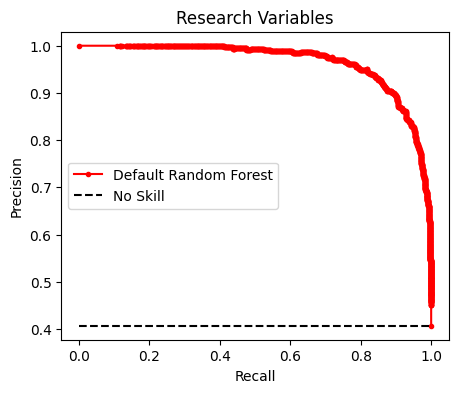

In [10]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [11]:
y_pred_ = best_model.predict(X_val)
precision_recall_fscore_support(y_val, y_pred_, labels=[1,0])

(array([0.90482574, 0.92205492]),
 array([0.88466579, 0.93615108]),
 array([0.89463221, 0.92904953]),
 array([ 763, 1112]))

In [12]:
best_params

{'min_samples_leaf': 4, 'min_samples_split': 2}

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [18]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

          feature  importance
0          WFFORM    0.130041
1           QCYL5    0.089766
2            POHM    0.068900
3       WALMAT_SS    0.068616
4            ENBI    0.064716
..            ...         ...
107        EVAP_C    0.000000
108      EVAP_C-H    0.000000
109  EVAP_DECABOA    0.000000
110       EVAP_TI    0.000000
111  EVAP_UNKNOWN    0.000000

[112 rows x 2 columns]


In [19]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['WFFORM', 'QCYL5', 'POHM', 'WALMAT_SS', 'ENBI', 'WMHD', 'PRAD',
       'LHTIME', 'PELLET_GAS-FUEL', 'ZEFF', 'PFLOSS', 'PLTH', 'EVAP_NONE',
       'NESOL', 'BEIMHD', 'ZEFFNEO', 'HYBRID_YES', 'DWDIA', 'TORQ',
       'LIMMAT_C', 'WFICFORM', 'PICRH', 'WALMAT_C', 'HYBRID_UNKNOWN',
       'PECRH', 'LIMMAT_W', 'ELMFREQ', 'CONFIG_SN', 'DIVMAT_W',
       'ELMTYPE_TYPE-I', 'PELLET_NONE', 'ELMTYPE_TYPE-II', 'HYBRID_NO',
       'DIVNAME_RIB', 'DIVNAME_DV-III', 'WALMAT_IN/C', 'WALMAT_IN',
       'DIVNAME_MARK', 'DIVNAME_RDP', 'PELLET_H', 'ICSCHEME_HMIN',
       'DIVNAME_OPEN', 'DIVNAME_DV-II', 'HYBRID_HYBRID',
       'DIVNAME_UNKNOWN', 'DIVNAME_MARKSR', 'ELMTYPE_TYPE-III',
       'PREMAG_UNKNOWN', 'ECHMODE_UNKNOWN', 'DIVNAME_PLATES1', 'DIVMAT_C',
       'AUXHEAT_NB', 'PREMAG_YES', 'ELMTYPE_UNKNOWN', 'PELLET_D',
       'WALMAT_C-W', 'PREMAG_NO', 'ICSCHEME_NONE', 'CONFIG_SN(L)',
       'DIVNAME_MARKIAP', 'AUXHEAT_NBEC', 'EVAP_BE', 'WALMAT_W',
       'AUXHEAT_NBIC', 'CONFIG_DN', 'DIVNAME_DV-I',

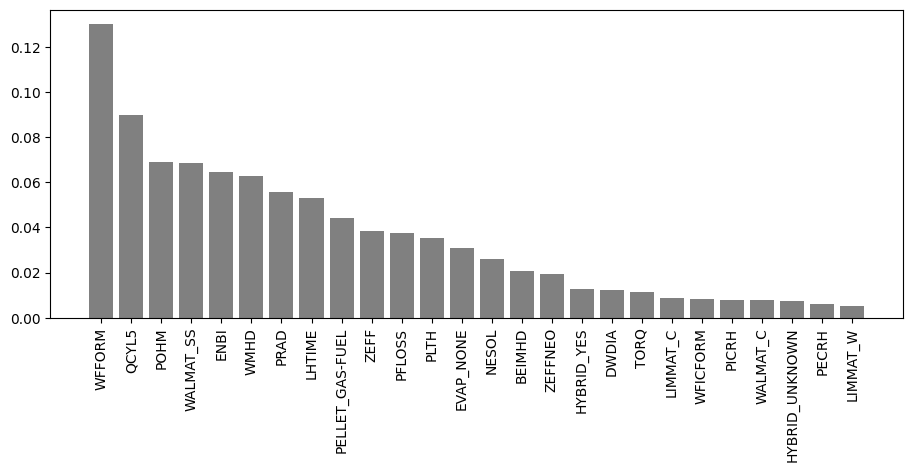

In [20]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [21]:
# Quite Important
df[df.importance > 1e-3]

,feature,importance
0,WFFORM,0.130041
1,QCYL5,0.089766
2,POHM,0.068900
3,WALMAT_SS,0.068616
4,ENBI,0.064716
5,WMHD,0.062576
6,PRAD,0.055917
7,LHTIME,0.053189
8,PELLET_GAS-FUEL,0.044088
9,ZEFF,0.038533


In [22]:
# Not so important
df[df.importance < 1e-3]

,feature,importance
49,DIVNAME_PLATES1,0.000981
50,DIVMAT_C,0.000974
51,AUXHEAT_NB,0.000968
52,PREMAG_YES,0.000959
53,ELMTYPE_UNKNOWN,0.000937
...,...,...
107,EVAP_C,0.000000
108,EVAP_C-H,0.000000
109,EVAP_DECABOA,0.000000
110,EVAP_TI,0.000000


In [25]:
df[df.importance == 0.000000]

,feature,importance
86,DIVMAT_TI12,0.0
87,LIMMAT_MO,0.0
88,DIVMAT_NONE,0.0
89,DIVMAT_MO,0.0
90,DIVMAT_SS,0.0
91,CONFIG_BOT,0.0
92,WALMAT_AL,0.0
93,DIVNAME_DIV1,0.0
94,CONFIG_DND,0.0
95,CONFIG_IW,0.0
